In [115]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import csv
import random 
import seaborn as sns 


In [124]:
# load your dataset using pandas
df = pd.read_csv('data/image_lst.csv')
df['lst1;'] = df['lst1;'].str.rstrip(';')
df.rename(columns= {'lst1;': 'lst'}, inplace= True)
df['lst'] = pd.to_numeric(df['lst'], errors='coerce')
df = df.dropna()
#drop columns
df2 = df.select_dtypes(['float'])

df3 = df[df['road'].notna()]

df3 = df3.drop(['mvt_id', 'ref_length', 'class', 'network', 'name', 'ref'], axis = 1)


df3.head()

#df.head()
df['lst'].dtype
print(df)
df['lst'].max()


      mvt_id      class network                  name   ref  ref_length  \
372       76  secondary    road         Holterbergweg  S111         4.0   
373       76  secondary    road         Holterbergweg  S111         4.0   
374       76  secondary    road         Holterbergweg  S111         4.0   
375       76  secondary    road         Holterbergweg  S111         4.0   
376       76  secondary    road         Holterbergweg  S111         4.0   
...      ...        ...     ...                   ...   ...         ...   
84492    264  secondary    road  Johan van Hasseltweg  S118         4.0   
84493    264  secondary    road  Johan van Hasseltweg  S118         4.0   
84494    265  secondary    road            Papaverweg  S118         4.0   
84495    266  secondary    road  Nieuwe Leeuwarderweg  S116         4.0   
84521    201      trunk    road  Nieuwe Leeuwarderweg  S116         4.0   

       distance       angle       id      road  ...       sky  buildings  \
372         0.0  331.18

/tmp/ipykernel_11624/505258074.py:2: DtypeWarning: Columns (0,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/image_lst.csv')


35.4289207458496

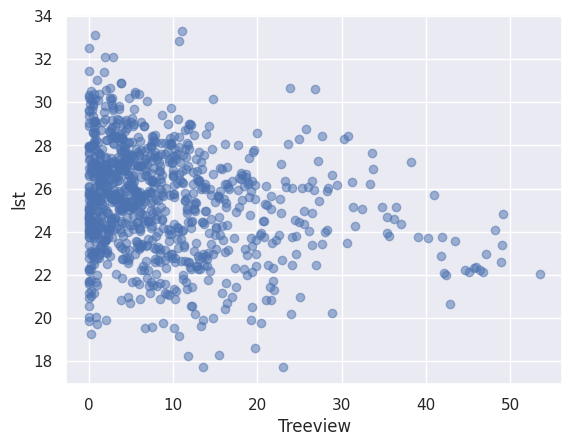

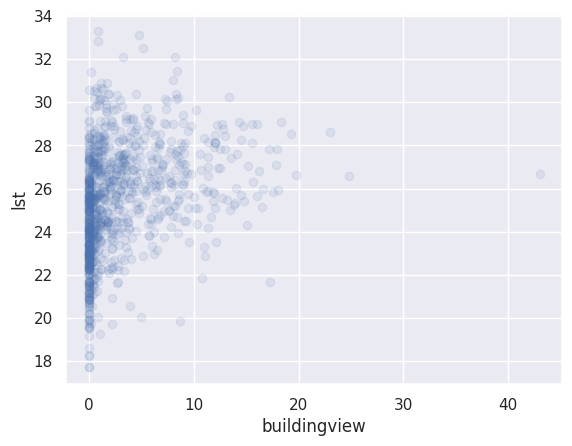

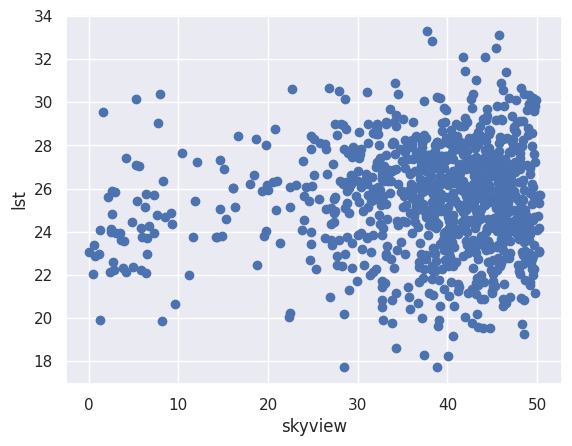

In [122]:
sample_size = 1000 

df_subset = df.sample(n= sample_size)

df_subset
sns.set()
#plot treeview 
plt.scatter(y= df_subset['lst'], x = df_subset['Trees'], alpha = 0.5)
plt.xlabel('Treeview')
plt.ylabel('lst')
plt.show()

# plot building view
plt.scatter(y= df_subset['lst'], x = df_subset['buildings'], alpha =0.1)
plt.xlabel('buildingview')
plt.ylabel('lst')
plt.show()

# plot skyview
plt.scatter(y= df_subset['lst'], x = df_subset['sky'])
plt.xlabel('skyview')
plt.ylabel('lst')
plt.show()

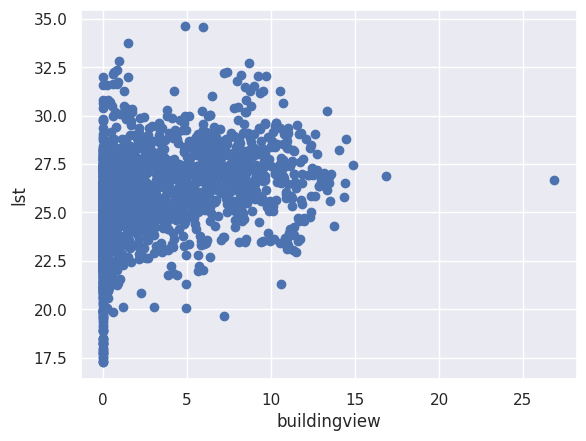

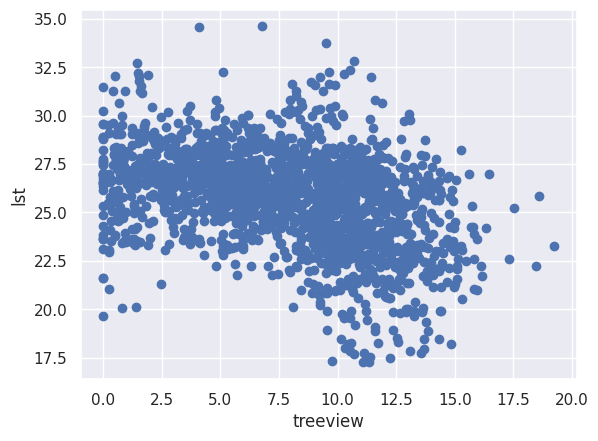

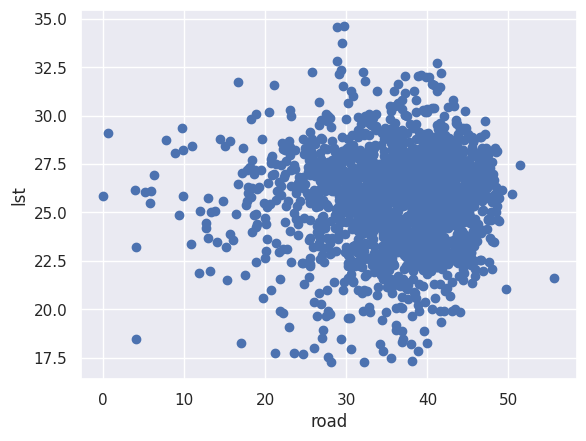

In [118]:
min_value = 38 
max_value = 42

subset_SVF = df[(df['sky']>= min_value) & (df['sky']<= max_value)]

sns.set()
# plot building view againts lst with constant skyview
plt.scatter(y= subset_SVF['lst'], x = subset_SVF['buildings'])
plt.xlabel('buildingview')
plt.ylabel('lst')
plt.show()


# plot treeview againts lst with constant skyview
plt.scatter(y= subset_SVF['lst'], x = subset_SVF['Trees'])
plt.xlabel('treeview')
plt.ylabel('lst')
plt.show()

# plot building view againts lst with constant skyview
plt.scatter(y= subset_SVF['lst'], x = subset_SVF['road'])
plt.xlabel('road')
plt.ylabel('lst')
plt.show()

Index(['mvt_id', 'class', 'network', 'name', 'ref', 'ref_length', 'distance',
       'angle', 'id', 'road', 'Trees', 'sky', 'buildings', 'people', 'bikes',
       'cars', 'pavement', 'river', 'water', 'UHI1', 'lst',
       'quantile_category'],
      dtype='object')


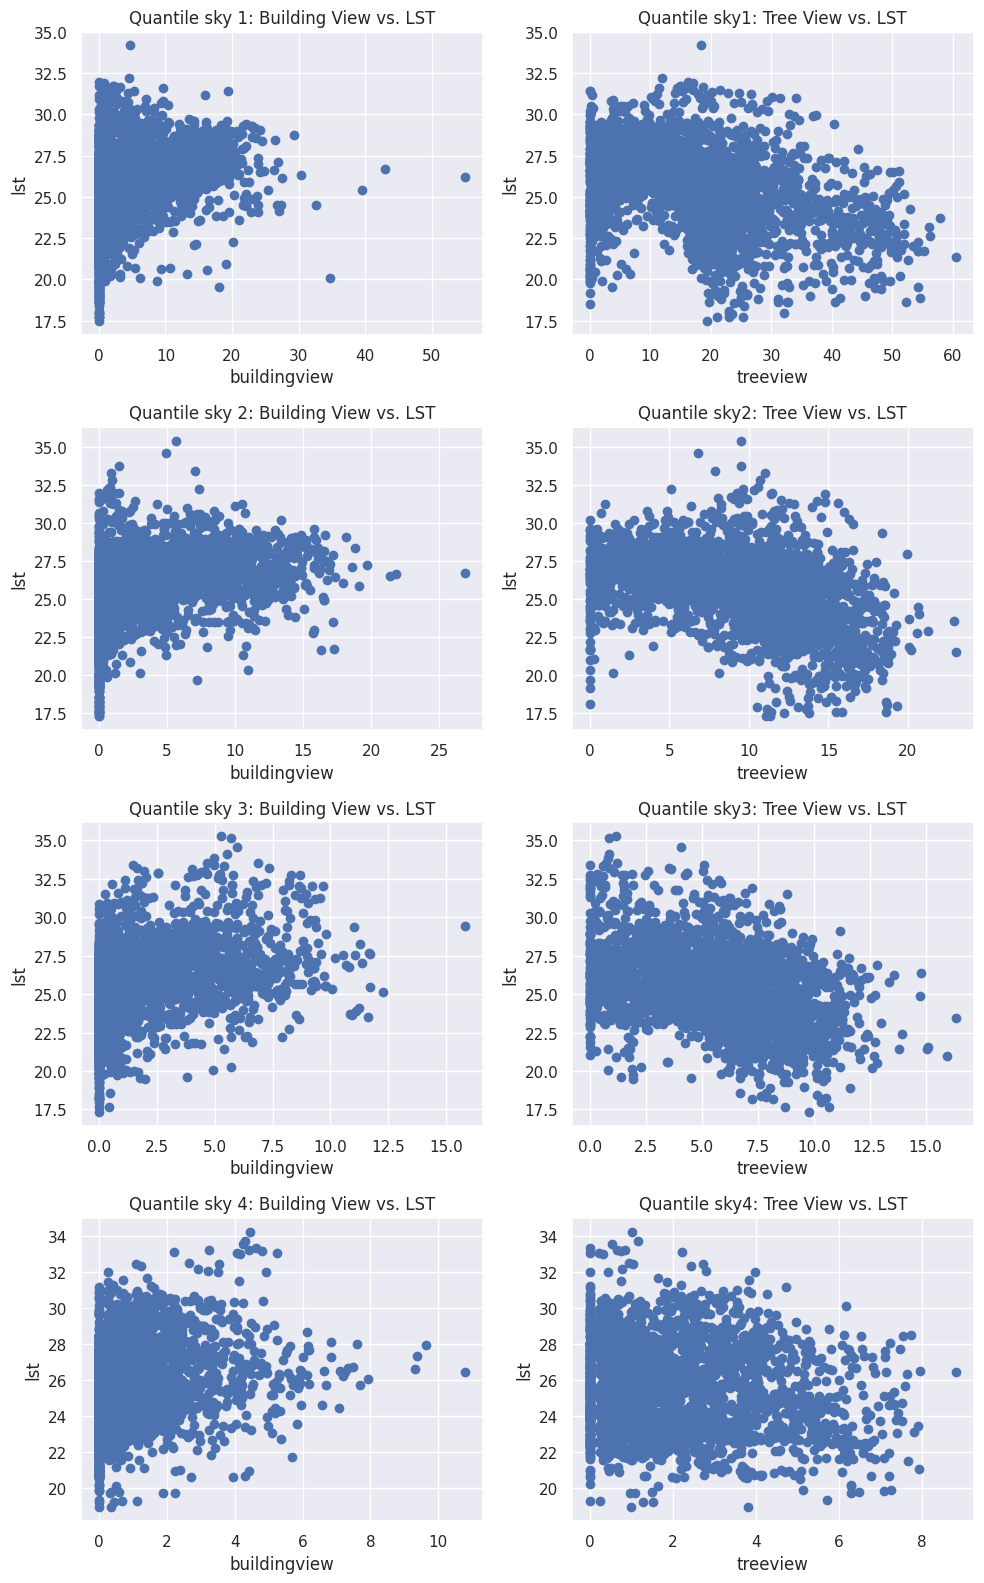

In [151]:
column_name = 'sky'

# Calculate the quantiles and assign labels to each quantile
quantile_labels = ['Q1', 'Q2', 'Q3', 'Q4']
df['quantile_category'] = pd.qcut(df[column_name], q=4, labels=quantile_labels)

# Subset the dataset based on quantile category
subset_q1 = df[df['quantile_category'] == 'Q1']
subset_q2 = df[df['quantile_category'] == 'Q2']
subset_q3 = df[df['quantile_category'] == 'Q3']
subset_q4 = df[df['quantile_category'] == 'Q4']

print(df.columns)
sns.set()

# Create a single figure and axes for all the plots
fig, axes = plt.subplots(4, 2, figsize=(10, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, subset in enumerate([subset_q1, subset_q2, subset_q3, subset_q4]):
    # Plot building view against lst with constant skyview
    axes[i*2].scatter(y=subset['lst'], x=subset['buildings'])
    axes[i*2].set_xlabel('buildingview')
    axes[i*2].set_ylabel('lst')
    axes[i*2].set_title(f'Quantile sky {i+1}: Building View vs. LST')

    # Plot treeview against lst with constant skyview
    axes[i*2+1].scatter(y=subset['lst'], x=subset['Trees'])
    axes[i*2+1].set_xlabel('treeview')
    axes[i*2+1].set_ylabel('lst')
    axes[i*2+1].set_title(f'Quantile sky{i+1}: Tree View vs. LST')

plt.tight_layout()
plt.show()



In [157]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


X = df.drop(['mvt_id','class' ,'network','name','ref','ref_length', 'distance', 'id', 'angle', 'lst',  'quantile_category', 'UHI1'], axis =1)
y = df['lst']

def lasso_tune(X, y):
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    Lasso_params = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100]}
    
    grid_search = GridSearchCV(Lasso(), Lasso_params, refit=True, scoring='neg_root_mean_squared_error').fit(X_train, y_train)

    # Print the best parameters found by GridSearchCV
    print('Best parameters:', grid_search.best_params_)

    # Evaluate the performance of the best Lasso model and print coefficients
    best_Lasso = grid_search.best_estimator_
    y_pred = best_Lasso.predict(X_test)
    coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_Lasso.coef_})
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('Test MSE:', mse, 'r2:', r2, 'coefficients:', coefficients_df)

    return best_Lasso

lasso_tune(X,y)

Best parameters: {'alpha': 0.001}
Test MSE: 5.2197488948067905 r2: 0.16857479719474255 coefficients:      Feature  Coefficient
0       road     0.006721
1      Trees    -0.058206
2        sky    -0.003962
3  buildings     0.120073
4     people     0.085012
5      bikes     0.064535
6       cars     0.082441
7   pavement     0.014814
8      river    -0.012692
9      water    -0.024259


Lasso(alpha=0.001)

In [160]:

from sklearn.ensemble import RandomForestRegressor


def rf_tune(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # rf_params = {'n_estimators':[100, 1000]}
    rf_params = {'n_estimators':[200, 500, 1000],
                  'max_features':['sqrt','log2'],
                  'min_samples_split':[2, 4, 8],
                  'min_samples_leaf':[0.001, 0.01, 0.1],
                  'n_jobs': [-1]}
    grid_search = GridSearchCV(RandomForestRegressor(), rf_params, scoring='neg_root_mean_squared_error').fit(X_train, y_train)

    # Print the best parameters found by GridSearchCV
    print('Best parameters:', grid_search.best_params_)

    # Evaluate the performance of the best MLP model on the test data
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('Test MSE:', mse, 'r2:', r2)


    return best_rf

rf_tune(X, y)



Best parameters: {'max_features': 'log2', 'min_samples_leaf': 0.001, 'min_samples_split': 8, 'n_estimators': 1000, 'n_jobs': -1}
Test MSE: 4.211737689142039 r2: 0.32913537932037173


RandomForestRegressor(max_features='log2', min_samples_leaf=0.001,
                      min_samples_split=8, n_estimators=1000, n_jobs=-1)